# The basic model with first-order condition

In [2]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
from dynamic_model.Basic import BasicModel
import tensorflow as tf
from dynamic_model.Networks import BellmanNet_FOC
from dynamic_model.Trainer import BellmanTrainer

In [3]:
model = BasicModel(   cost_type = "None")
net = BellmanNet_FOC(model)

Trainer =  BellmanTrainer(model, net, hidden_dim=[32,  32], nu = 10, lr=1e-4)

Trainer.fit(training_steps = 10000, display_step=2000, eval= True,  early_stop = False,  eval_interval=10, n_eval_points = 8192, reward_drop_tolerance = 20)

2025-12-31 04:31:06.464677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14633 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2025-12-31 04:31:06.465460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14633 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2025-12-31 04:31:06.466081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14634 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2025-12-31 04:31:06.466705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14634 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id

Starting training ...
Network weights initialized.


2025-12-31 04:31:09.572265: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xc2a0c010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-31 04:31:09.572286: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-12-31 04:31:09.572292: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-12-31 04:31:09.572297: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-12-31 04:31:09.572301: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-12-31 04:31:09.579530: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-31 04:31:0

Epoch     1 | loss_total=1.587418e+05 | loss_V=1.587319e+05 | loss_FOC=9.825714e-01
 Eval @ epoch 1: lifetime reward = 4.112e+02


Training progress:  20%|█████████████▉                                                        | 1990/10000 [00:41<02:23]

Epoch  2000 | loss_total=2.813491e+02 | loss_V=2.803105e+02 | loss_FOC=1.038645e-01
 Eval @ epoch 2000: lifetime reward = 4.937e+02


Training progress:  40%|███████████████████████████▉                                          | 3990/10000 [01:17<01:51]

Epoch  4000 | loss_total=3.492137e+02 | loss_V=3.486580e+02 | loss_FOC=5.556728e-02
 Eval @ epoch 4000: lifetime reward = 5.181e+02


Training progress:  60%|█████████████████████████████████████████▉                            | 5990/10000 [01:54<01:11]

Epoch  6000 | loss_total=2.015130e+02 | loss_V=2.014700e+02 | loss_FOC=4.298494e-03
 Eval @ epoch 6000: lifetime reward = 7.140e+02


Training progress:  80%|███████████████████████████████████████████████████████▉              | 7999/10000 [02:31<00:32]

Epoch  8000 | loss_total=2.336290e+02 | loss_V=2.336195e+02 | loss_FOC=1.434375e-03
 Eval @ epoch 8000: lifetime reward = -1.560e+06


Training progress: 100%|█████████████████████████████████████████████████████████████████████▉| 9990/10000 [03:08<00:00]

Epoch 10000 | loss_total=1.555495e+02 | loss_V=1.553119e+02 | loss_FOC=2.376072e-02
 Eval @ epoch 10000: lifetime reward = -1.387e+15


Training progress: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [03:08<00:00]

Training completed.
Best reward: 8.799e+02 @ epoch 7090


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(logs):

    required_keys = ['loss_history', 'loss_bellman', 'loss_foc']
    missing = [k for k in required_keys if k not in logs]
    if missing:
        raise KeyError(f"缺少必要的key: {missing}")

    best_epoch = logs.get('best_epoch', None)
    overfit_epoch = logs.get('overfit_epoch', None)

    keys = ['loss_history', 'loss_bellman', 'loss_foc']
    titles = ['Total Loss', 'Bellman Residual', 'FOC Residual']
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, key, title, color in zip(axes, keys, titles, colors):
        values = np.asarray(logs[key])
        steps = np.arange(1, len(values) + 1)

        ymin, ymax = np.min(values), np.max(values)
        pad = 0.05 * (ymax - ymin + 1e-8)
        ax.set_ylim(ymin - pad, ymax + pad)

       
        if best_epoch and best_epoch < len(values):
            ax.plot(steps[:best_epoch], values[:best_epoch], color=color, lw=2, label='Training Loss')
            ax.plot(steps[best_epoch-1:], values[best_epoch-1:], color=color, lw=2, linestyle='--', alpha=0.7)
            ax.axvline(best_epoch, color=color, linestyle=':', lw=1.8, label=f'Best Epoch')
            ax.text(best_epoch, ymin + (ymax - ymin) * 0.9, f"Best", color='red',
                    fontsize=10, ha='center', va='top', fontweight='bold')
        else:
            ax.plot(steps, values, color=color, lw=2, label='Training Loss')

        #if overfit_epoch and overfit_epoch <= len(values):
            #ax.axvline(overfit_epoch, color='purple', linestyle='-.', lw=1.5,)
                       #label=f'Overfit Epoch = {overfit_epoch}')
            #ax.text(overfit_epoch, ymin + (ymax - ymin) * 0.8, f"Overfit\n{overfit_epoch}",
                    #color='purple', fontsize=9, ha='center', va='top', fontweight='bold')

       
        ax.set_title(title, fontsize=13, weight="bold")
        ax.set_xlim(0, len(values))
        ax.set_xlabel("Training Steps", fontsize=11)
        ax.set_ylabel("Loss Value", fontsize=11)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8, loc='best')

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_curves(logs, max_train_steps=None):

    required_keys = ['eval_epochs', 'eval_euler_resid', 'eval_lifetime_reward']
    missing = [k for k in required_keys if k not in logs]
    if missing:
        raise KeyError(f"缺少必要的 key: {missing}")

    eval_epochs = np.asarray(logs['eval_epochs'])
    euler_resid = np.asarray(logs['eval_euler_resid'])
    lifetime_reward = np.asarray(logs['eval_lifetime_reward'])

    best_epoch = logs.get('best_epoch', None)
    overfit_epoch = logs.get('overfit_epoch', None)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # =Euler Residual ====
    ax = axes[0]
    color = 'tab:red'
    ax.plot(eval_epochs, euler_resid, linestyle='solid', color=color, lw=1, label='Euler Residual')
    ax.set_xlabel('Training Steps ', fontsize=12)
    ax.set_ylabel('Euler Residual', fontsize=12,)
    ax.tick_params(axis='y')
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    ymin, ymax = np.min(euler_resid), np.max(euler_resid)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_title('Euler Residual', fontsize=13, weight='bold')
    ax.grid(alpha=0.3)
    ax.legend()

    # ==== 图 2: Lifetime Reward ====
    ax = axes[1]
    color = 'tab:purple'

    if best_epoch and best_epoch in eval_epochs:
        idx_best = np.where(eval_epochs == best_epoch)[0][0]
    
        ax.plot(eval_epochs[:idx_best+1], lifetime_reward[:idx_best+1],
                linestyle='solid', color=color, lw= 2, label='Reward (pre-best)')
        
        if idx_best < len(eval_epochs) - 1:
            ax.plot(eval_epochs[idx_best:], lifetime_reward[idx_best:], 
                    linestyle='--', color='blue', lw= 2, alpha=0.7, label='Reward (post-best)')
        # 标记 best_epoch
        ax.axvline(best_epoch, color=color, linestyle=':', lw=2)
        ax.text(best_epoch, np.max(lifetime_reward), f"Best",
                color= 'red', fontsize=9, ha='center', va='bottom', fontweight='bold')
    else:
        ax.plot(eval_epochs, lifetime_reward, 's--', color=color, lw=2, label='Lifetime Reward')

    # 标出 overfit_epoch（如果存在）
    #if overfit_epoch and overfit_epoch in eval_epochs:
    #    ax.axvline(overfit_epoch, color='orange', linestyle='-.', lw= 2)
    #    ax.text(overfit_epoch, np.max(lifetime_reward)*0.97,
               # f"Overfit {overfit_epoch}", color='orange', fontsize=9,
               # ha='center', va='top', fontweight='bold')

    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Lifetime Reward', fontsize=12)
    ax.tick_params(axis='y') #, labelcolor=color)
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    ymin, ymax = np.min(lifetime_reward), np.max(lifetime_reward)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.grid(alpha=0.3)
    ax.set_title('Lifetime Reward', fontsize=13, weight='bold')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()
    

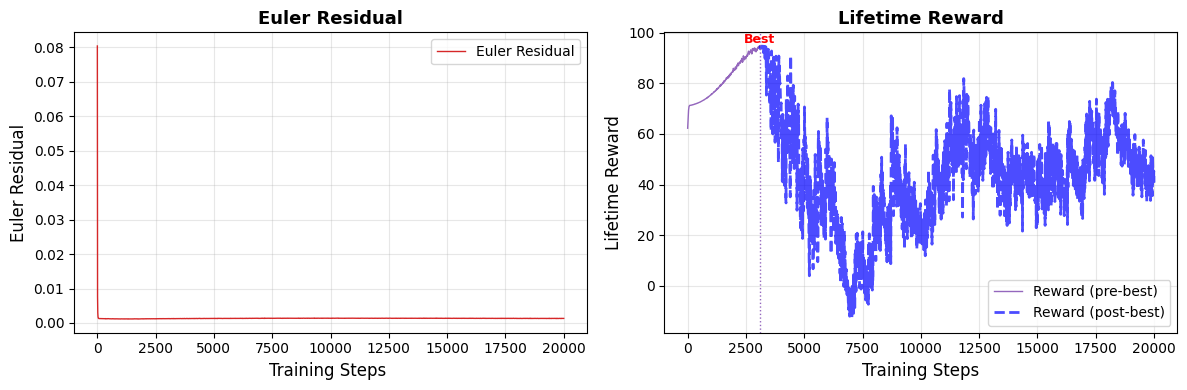

In [ ]:
plot_evaluation_curves(Trainer.__dict__)